In [1]:
from bs4 import BeautifulSoup
from requests import get
import random
from dataclasses import dataclass, asdict
from urllib.parse import urlparse
import pandas as pd

_useragent_list = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
    'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36 Edg/111.0.1661.62',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/111.0'
]

def get_useragent():
    return random.choice(_useragent_list)

def _req(term, results, lang, timeout):
    resp = get(
        url="https://www.google.com/search",
        headers={
            "User-Agent": get_useragent()
        },
        params={
            "q": term,
            "num": results, 
            "hl": lang,
        },
        timeout=timeout,
    )
    return resp

from datetime import datetime

@dataclass()
class SearchResult:
    url: str
    search_term:str
    organic:bool
    position:int
    search_date:datetime

    def to_dict(self):
        return {
            "url":self.url,
            "search_term":self.search_term,
            "organic":self.organic,
            "organic":self.organic,
            "position":self.position,
            "search_date":self.search_date,
        }


def search(term, num_results=10, lang="es", timeout=5):
    """Search the Google search engine"""

    search_date = datetime.now()
    
    escaped_term = term.replace(" ", "+")

    resp = _req(escaped_term, num_results, lang, timeout)
    
    soup = BeautifulSoup(resp.text, "html.parser")
    search_results = list()

    sem_block = soup.find("div", attrs = {"id":"tads"})
    n_sem = 0
    if sem_block is not None:
        sem_block = sem_block.find_all("div", attrs = {"data-text-ad":"1"})
        for r in sem_block:
            link = urlparse(r.find("a",href=True)["href"])
            if link.netloc != "www.google.com":
                search_results.append(SearchResult(
                    url = link.netloc,
                    search_term=term,
                    organic=False,
                    position=n_sem,
                    search_date=search_date
                ).to_dict())
                n_sem+=1

    seo_block = soup.find("div", attrs = {"id":"rso"}).find_all("div", attrs={"class": "g"})
    n_seo = 0
    for r in seo_block:
        link = urlparse(r.find("a", href=True)["href"])
        if link.netloc != "":
            
            search_results.append(SearchResult(
                url = link.netloc,
                search_term=term,
                organic=True,
                position=n_sem+n_seo,
                search_date=search_date
            ).to_dict())
            n_seo += 1
    return pd.DataFrame(search_results)

In [2]:
result = search(
    "alquiler madrid verano",
    num_results=20,
    lang="es"    
)

In [3]:
result

,url,search_term,organic,position,search_date
0,www.holidu.es,alquiler madrid verano,False,0,2023-04-26 11:11:23.834718
1,es.rentalia.com,alquiler madrid verano,True,1,2023-04-26 11:11:23.834718
2,www.hometogo.es,alquiler madrid verano,True,2,2023-04-26 11:11:23.834718
3,www.holidu.es,alquiler madrid verano,True,3,2023-04-26 11:11:23.834718
4,www.airbnb.es,alquiler madrid verano,True,4,2023-04-26 11:11:23.834718
5,www.milanuncios.com,alquiler madrid verano,True,5,2023-04-26 11:11:23.834718
6,www.idealista.com,alquiler madrid verano,True,6,2023-04-26 11:11:23.834718
7,www.vrbo.com,alquiler madrid verano,True,7,2023-04-26 11:11:23.834718
8,www.casamundo.es,alquiler madrid verano,True,8,2023-04-26 11:11:23.834718
9,www.expedia.es,alquiler madrid verano,True,9,2023-04-26 11:11:23.834718


In [4]:
import re
from itertools import combinations, permutations

import pandas as pd


def kw_generate(products, 
                words, 
                max_len=3,
                match_types=['Exact', 'Phrase', 'Broad', 'Modified'],
                capitalize_adgroups=True,
                order_matters=True, 
                campaign_name='SEM_Campaign'
                ):
    """Generate a data frame of keywords using a list of products and relevant
    words.
    """
    match_types = [x.title() for x in match_types]
    possible_match_types = ['Exact', 'Phrase', 'Broad', 'Modified']
    if not set(match_types).issubset(possible_match_types):
        raise ValueError('please make sure match types are any of '
                         + str(possible_match_types))

    if max_len < 2:
        raise ValueError('please make sure max_len is >= 2')

    comb_func = permutations if order_matters else combinations
    headers = ['Campaign', 'Ad Group', 'Keyword', 'Criterion Type', 'Labels']
    keywords_list = []
    for prod in products:
        for i in range(2, max_len+1):
            for comb in comb_func([prod] + words, i):
                if prod not in comb:
                    continue
                for match in match_types:
                    row = [
                        campaign_name,
                        prod.title() if capitalize_adgroups else prod,
                        (' '.join(comb) if match != 'Modified' else
                            '+' + ' '.join(comb).replace(' ', ' +')),
                        match if match != 'Modified' else 'Broad',
                        ';'.join([x.title() for x in comb if x != prod])
                    ]
                    keywords_list.append(row)
    return pd.DataFrame.from_records(keywords_list, columns=headers)


def kw_broad(words):
    """Return :attr:`words` in broad match.
    """
    regex = r'^\'|^\"|\'$|\"$|\+|^\[|\]$|^-'
    return [re.sub(regex, '', x) for x in words]


def kw_exact(words):
    """Return :attr:`words` in exact match.
    """
    return ['[' + w + ']' for w in kw_broad(words)]


def kw_phrase(words):
    """Return :attr:`words` in phrase match.
    """
    return ['"' + w + '"' for w in kw_broad(words)]


def kw_modified(words):
    """Return :attr:`words` in modified broad match.
    """
    return ['+' + w.replace(' ', ' +') for w in kw_broad(words)]


def kw_neg_broad(words):
    """Return :attr:`words` in negative broad match.
    """
    return ['-' + w for w in kw_broad(words)]


def kw_neg_phrase(words):
    """Return :attr:`words` in negative phrase match.
    """
    return ['-' + w for w in kw_phrase(words)]


def kw_neg_exact(words):
    """Return :attr:`words` in negative exact match.
    """
    return ['-' + w for w in kw_exact(words)]

In [5]:
products = ['toyota']
words = ['compra', 'oferta',"venta"]
kws = kw_generate(
    products,
    words,
    match_types=['Exact'],
    max_len=2,
)
kws.head()

,Campaign,Ad Group,Keyword,Criterion Type,Labels
0,SEM_Campaign,Toyota,toyota compra,Exact,Compra
1,SEM_Campaign,Toyota,toyota oferta,Exact,Oferta
2,SEM_Campaign,Toyota,toyota venta,Exact,Venta
3,SEM_Campaign,Toyota,compra toyota,Exact,Compra
4,SEM_Campaign,Toyota,oferta toyota,Exact,Oferta


In [6]:
search_res = []
for kw in kws['Keyword'].values.tolist():
    result = search(
        kw,
        num_results=10,
        lang="es"    
    )
    search_res.append(result)
search_res = pd.concat(search_res)

In [7]:
search_res

,url,search_term,organic,position,search_date
0,www.toyota.es,toyota compra,False,0,2023-04-26 11:12:04.754065
1,www.carwow.es,toyota compra,False,1,2023-04-26 11:12:04.754065
2,www.grupogamboa.com,toyota compra,False,2,2023-04-26 11:12:04.754065
3,www.toyota.es,toyota compra,True,3,2023-04-26 11:12:04.754065
4,www.toyota.es,toyota compra,True,4,2023-04-26 11:12:04.754065
5,www.toyota.es,toyota compra,True,5,2023-04-26 11:12:04.754065
6,www.toyota.es,toyota compra,True,6,2023-04-26 11:12:04.754065
7,www.toyota.es,toyota compra,True,7,2023-04-26 11:12:04.754065
8,www.toyota.es,toyota compra,True,8,2023-04-26 11:12:04.754065
9,www.toyota.es,toyota compra,True,9,2023-04-26 11:12:04.754065


<Axes: xlabel='count', ylabel='url'>

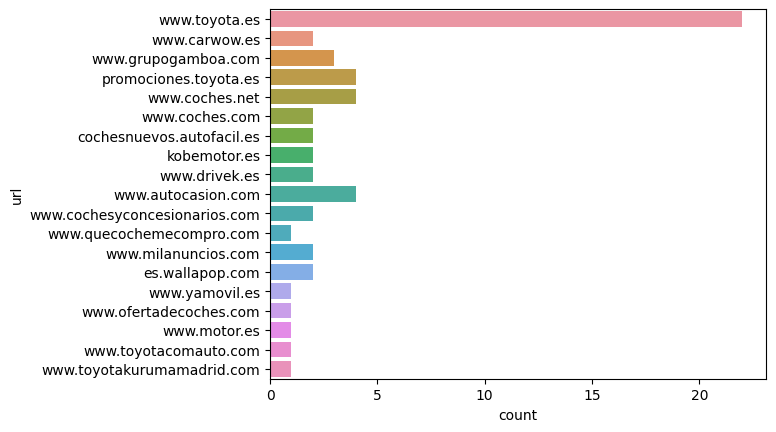

In [8]:
import seaborn as sns

sns.countplot(search_res, y='url')

<Axes: xlabel='count', ylabel='url'>

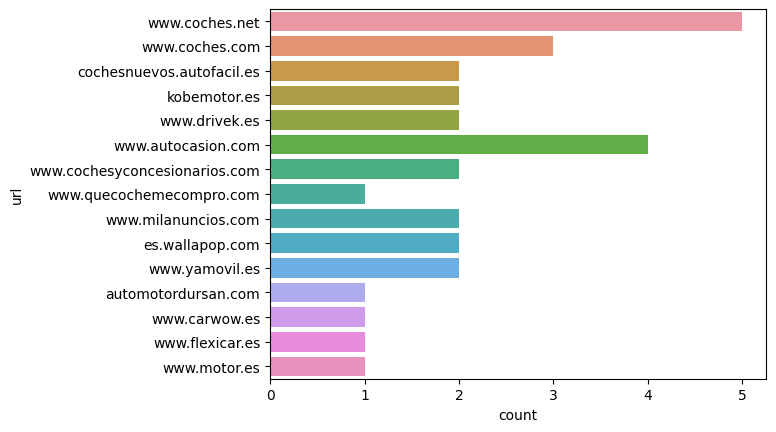

In [41]:
sns.countplot(
    search_res[~search_res['url'].str.contains('toyota')],
    y='url'
)

<Axes: xlabel='count', ylabel='url'>

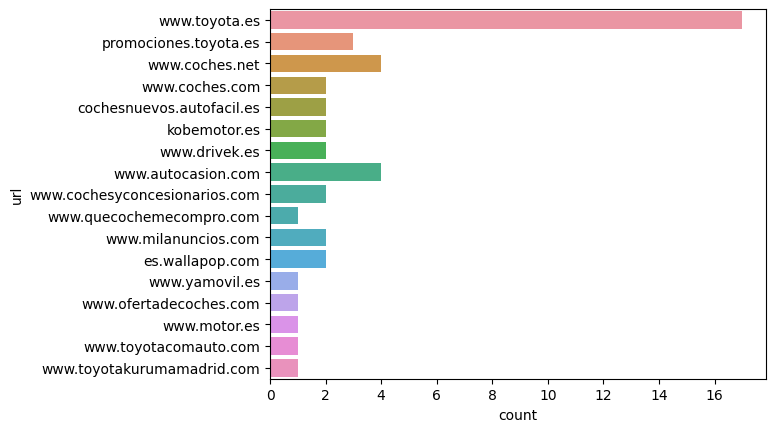

In [9]:
sns.countplot(
    search_res[search_res['organic']==1],
    y='url',
)

<Axes: xlabel='position', ylabel='url'>

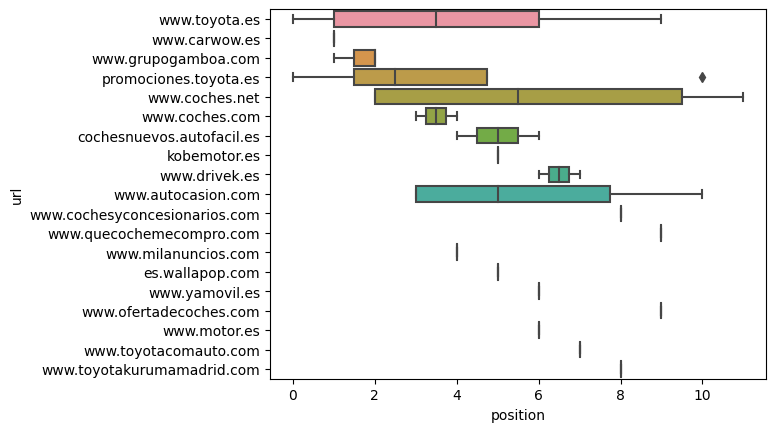

In [10]:
sns.boxplot(
    search_res,
    y='url',
    x='position'
)

<Axes: xlabel='position', ylabel='url'>

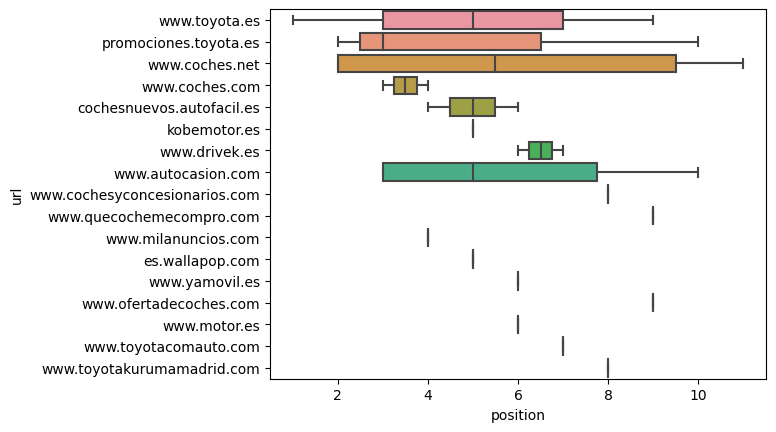

In [11]:
sns.boxplot(
    search_res[search_res['organic']==1],
    y='url',
    x='position'
)